<a href="https://colab.research.google.com/github/yejinPARK48/VerifyNews_using_Transformer/blob/main/FakeNews_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Install and Setup

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"guetteguette","key":"a60669d4067f925d044b4a9f122f2f2c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


2. Download the dataset form Kaggle

In [ ]:
!kaggle datasets download -d saurabhshahane/fake-news-classification
!unzip fake-news-classification.zip

Dataset URL: https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification
License(s): Attribution 4.0 International (CC BY 4.0)
 94% 87.0M/92.1M [00:01<00:00, 85.3MB/s]
100% 92.1M/92.1M [00:01<00:00, 77.5MB/s]
Archive:  fake-news-classification.zip
  inflating: WELFake_Dataset.csv     


3. Data Loading and Preprocessing

In [ ]:
import pandas as pd

# Load the Data
data = pd.read_csv("WELFake_Dataset.csv")

# Check the Data
print(data.head())
print(data.columns)


   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  
Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')


In [ ]:
data.drop('Unnamed: 0',axis=1,inplace=True)

data.rename(columns={'label':'labels'},inplace=True)

data.head()

,title,text,labels
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [ ]:
data.shape

(72134, 3)

In [ ]:
# Null values
data.isna().sum()

,0
title,558
text,39
labels,0


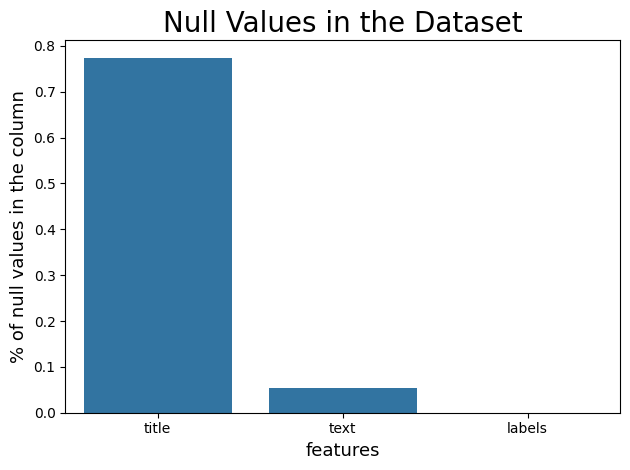

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Import the seaborn library


In [ ]:
data.dropna(axis=0,inplace=True)

In [ ]:
# Duplicate values (or better, duplicate rows)
data.duplicated().sum()

8416

In [ ]:
data.drop_duplicates(inplace=True)

data.shape

(63121, 3)

In [ ]:
# Shuffle the dataframe
data = data.sample(frac=1,random_state=42)

In [ ]:
# Check label distribution
print(data['labels'].value_counts())

# Check basic statistics
print(data.describe())
print(data.info())


labels
0    34791
1    28330
Name: count, dtype: int64
             labels
count  63121.000000
mean       0.448821
std        0.497378
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
<class 'pandas.core.frame.DataFrame'>
Index: 63121 entries, 71361 to 63490
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   63121 non-null  object
 1   text    63121 non-null  object
 2   labels  63121 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.9+ MB
None


In [ ]:
from sklearn.model_selection import train_test_split

# Train/Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['text'], data['labels'], test_size=0.2, random_state=42
)


In [ ]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer

# Load BERT Tokenizer (using Fast Tokenizer)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Define tokenization function
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=512)

# Hugging Face Dataset
train_dataset = Dataset.from_dict({"text": train_texts, "labels": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "labels": val_labels})

In [ ]:
# Batch tokenization (remove num_proc)
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/50496 [00:00<?, ? examples/s]

Map:   0%|          | 0/12625 [00:00<?, ? examples/s]

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
# Remove 'text' column (leaving only input_ids, attention_mask, labels needed by the model)
train_dataset = train_dataset.remove_columns(["text"])
val_dataset = val_dataset.remove_columns(["text"])


In [ ]:
# Set to Torch format (using PyTorch tensors)
train_dataset.set_format("torch")
val_dataset.set_format("torch")

In [ ]:
from transformers import TrainingArguments

# Learning Settings
training_args = TrainingArguments(
    output_dir="./results",           # 모델 저장 경로
    evaluation_strategy="epoch",     # 매 epoch마다 검증 수행
    learning_rate=2e-5,              # 학습률
    per_device_train_batch_size=16,  # 학습 배치 크기
    per_device_eval_batch_size=16,   # 검증 배치 크기
    num_train_epochs=3,              # 학습 epoch 수
    weight_decay=0.01,               # 가중치 감소
    logging_dir="./logs",            # 로그 저장 경로
    logging_steps=100,               # 로깅 간격
    save_total_limit=2,              # 저장할 체크포인트 개수
    report_to="none"                 # W&B 비활성화
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import AutoModelForSequenceClassification

# BERT model definition
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer

# Trainer 정의
trainer = Trainer(
    model=model,                     # 사전 학습된 BERT 모델
    args=training_args,              # 학습 설정
    train_dataset=train_dataset,     # 학습 데이터셋
    eval_dataset=val_dataset         # 검증 데이터셋
)


In [ ]:
# 학습 시작
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 